In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt

SECONDS_IN_HOUR = 3600

In [2]:
# Figure settings
LATEX_PREAMBLE = [
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
]

plt.rcParams.update({
    "grid.alpha": 0.5,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "ytick.labelsize": 6,
    "xtick.labelsize": 6,
    "font.size": 8,
    "font.family": "sans",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "text.latex.preamble": "".join(LATEX_PREAMBLE)
})

# Plotting utilities
def power(x): return x[POWER_INDICES], "Power ($p_i(t)$) [kWh]"
def soc(x): return x[SOC_INDICES] / SECONDS_IN_HOUR, "SoC ($b_i(t)$) [kWh]"
def is_active(x): pass 

In [3]:
def precedence(x): # 0 / 0 -> 0
    return params["rush"] * np.divide(
        params["max_soc"] - x[SOC_INDICES],
        params["max_soc"], 
        out=np.zeros_like(x[SOC_INDICES]), 
        where=params["max_soc"]!=0
    )

def rho(x):
    g = precedence(x)
    return x[IS_ACTIVE_INDICES] * x[IS_ACTIVE_INDICES, None]*\
           np.maximum(0, params["max_net_power"][:,None] - x[POWER_INDICES,None])*\
           np.maximum(0, g[:,None] - g)

        
def dx(t, x): # Parameters are taken as globals
    r = x[POWER_INDICES] * rho(x)
    return np.hstack([
        np.sum(r,1) - np.sum(r,0), # power dynamics
        params["efficiency"] * x[POWER_INDICES], # state-of-charge dynamics
        np.zeros(NUM_AGENTS) # is_active dynamics, i.e. trivially null
    ])
          

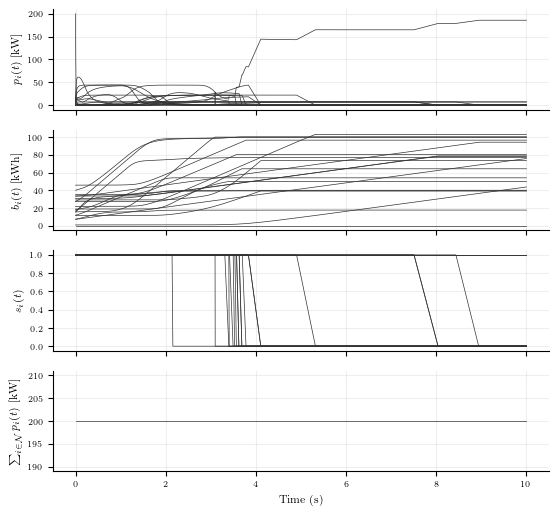

In [21]:
# System settings
NUM_CHARGING_STATION = 20
NUM_AGENTS = NUM_CHARGING_STATION + 1
MIN_EFFICIENCY = 0.98
INIT_SOC_FRAC = 0.5
AVAILABILITY = 200

# Load data and add rush and efficiency columns for the EVs data
EVS_DF = pd.read_csv("../data/EVs.csv")
CSS_DF = pd.read_csv("../data/CSs.csv")
# EVS_DF["max_soc"] *= SECONDS_IN_HOUR # kWh -> kWs 

# Simulation settings
T_BOUND = 10

# Variables indexing
RETAILER_POWER_INDEX = NUM_CHARGING_STATION
POWER_INDICES        = np.arange(NUM_AGENTS)
SOC_INDICES          = np.arange(NUM_AGENTS, 2*NUM_AGENTS)
IS_ACTIVE_INDICES    = np.arange(2*NUM_AGENTS, 3*NUM_AGENTS) 

# Sample CSs and PEVs, add necessary columns, and create paramteres
params_df = pd.concat((
        EVS_DF.sample(NUM_CHARGING_STATION, replace=True, ignore_index=True),
        CSS_DF.sample(NUM_CHARGING_STATION, replace=True, ignore_index=True),
        pd.DataFrame({"rush": np.random.rand(NUM_CHARGING_STATION), 
                      "efficiency": np.random.uniform(low=MIN_EFFICIENCY, size=NUM_CHARGING_STATION)})
    ),
    axis=1
)
params_df = pd.concat((
    params_df, 
    pd.DataFrame({"ev_name": ["Empty"], "max_input_power": [np.inf], 
                  "max_soc": [0], "rush": [0], "efficiency": [0],
                  "css_type": ["Retailer"], "max_output_power": [AVAILABILITY]}),
    )
)
params_df["max_net_power"] = params_df[["max_input_power", "max_output_power"]].min(axis=1)

params = np.array(params_df.to_records(index=False))

# Initial values
init_x = np.hstack([
    np.hstack([np.zeros(NUM_CHARGING_STATION), AVAILABILITY]), # init power
    INIT_SOC_FRAC * params["max_soc"] * np.random.rand(NUM_AGENTS), # init_soc
    (params["max_soc"] > 0) # init is_active
])
init_x[-1] = 1 # the retailer is always active

# System loop
system = sp.integrate.RK23(dx, y0=init_x, t0=0, t_bound=10)
y, t = [], []
while system.status != "finished":
    system.step()
    y.append(system.y)
    t.append(system.t)

    # Jumps
    system.y[IS_ACTIVE_INDICES] = (system.y[SOC_INDICES] <= params["max_soc"])
    system.y[RETAILER_POWER_INDEX] += np.sum(system.y[POWER_INDICES] * (1 - system.y[IS_ACTIVE_INDICES]))
    system.y[POWER_INDICES] *= system.y[IS_ACTIVE_INDICES]

# Plotting
Y = np.array(y)
fig, axs = plt.subplots(4, 1, figsize=(6.4,6), sharex=True)
axs[-1].set_xlabel("Time (s)")

for i,(indices, y_label) in enumerate((
    (POWER_INDICES, "$p_i(t)$ [kW]"), (SOC_INDICES, "$b_i(t)$ [kWh]"), (IS_ACTIVE_INDICES, "$s_i(t)$"))
):
    axs[i].plot(t, Y[:,indices], color="#333333", linewidth=0.5)
    axs[i].set_ylabel(y_label)
    axs[i].grid(alpha=0.2)

axs[-1].plot(t, Y[:,POWER_INDICES].sum(1), color="#333333", linewidth=0.5)
axs[-1].set_ylabel(r"$\sum_{i \in \mathcal{N}} p_i(t)$ [kW]")
axs[-1].grid(alpha=0.2)

plt.show()


In [22]:
Y[:,IS_ACTIVE_INDICES]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [311]:
CSS_DF

,type,max_output_power
0,slow,7
1,medium,22
2,fast,44
3,ultrafast,100


In [305]:
system = sp.integrate.RK23(dx, t0=0, y0=var, t_bound=10)

TypeError: Cannot cast array data from dtype([('power', '<f4'), ('soc', '<f4')]) to dtype('float64') according to the rule 'unsafe'

In [298]:
var.shape

(11,)

In [301]:
param

rec.array([('Nissan e-NV200 evalia',  50.,  40. , 'fast',  44.),
           ('Renault Zoe R135',  50.,  52. , 'fast',  44.),
           ('Peugeot e-208', 100.,  50. , 'medium',  22.),
           ('Audi e-tron Sportback 55 quattro', 150.,  95. , 'medium',  22.),
           ('Hyundai Kona electric 39.2kWh', 100.,  39.2, 'ultrafast', 100.),
           ('Porsche Taycan Turbo', 270.,  93.4, 'fast',  44.),
           ('Hyundai Kona electric 39.2kWh', 100.,  39.2, 'ultrafast', 100.),
           ('Mini Cooper SE',  50.,  28.9, 'medium',  22.),
           ('Tesla Model X Long Range Plus', 150., 100. , 'slow',   7.),
           ('Porsche Taycan Turbo S', 270.,  93.4, 'ultrafast', 100.)],
          dtype=[('pev_name', 'O'), ('max_input_power', '<f4'), ('max_soc', '<f4'), ('type', 'O'), ('max_output_power', '<f4')])

In [295]:
np.array([0, 3], dtype=[("power", "f4"), ("soc", "f4")])

array([(0., 0.), (3., 3.)], dtype=[('power', '<f4'), ('soc', '<f4')])

In [287]:
np.zeros(NUM_CHARGING_STATION+1).shape

(11,)

In [276]:
INIT_SOC_FRAC*param["max_soc"][:,None]


array([[27. ],
       [ 8.8],
       [40. ],
       [19.6],
       [37.5],
       [40. ],
       [47.5],
       [38.5],
       [18.4],
       [37.5]], dtype=float32)

In [149]:
max(len(l) for l in pevs_df["pev_name"])

36

In [127]:
pevs_df = pd.read_csv("../data/EVs.csv")

pevs = tuple(PEV(
        name=pevs_df.loc[i].pev_name, 
        soc=pevs_df.loc[i].max_soc*unit.kWh, 
        max_soc=pevs_df.loc[i].max_soc*unit.kWh,
        max_input=pevs_df.loc[i].max_input_power*unit.kW
    ) for i in range(10)
)

socs = [pev.soc for pev in pevs]

In [140]:
x = np.array([('Rex', 9, 81.0), ('Fido', 3, 27.0)],
             dtype=[('name', 'U10'), ('age', 'i4'), ('weight', 'f4')])

In [139]:
pevs

(Audi e-tron 55 quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 95.0 kWh,
 	- SoC: 95.0 kWh (100.0 %),
 Audi e-tron 50 quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 71.0 kWh,
 	- SoC: 71.0 kWh (100.0 %),
 Audi e-tron S quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 95.0 kWh,
 	- SoC: 95.0 kWh (100.0 %),
 Audi e-tron Sportback 50 quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 71.0 kWh,
 	- SoC: 71.0 kWh (100.0 %),
 Audi e-tron Sportback 55 quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 95.0 kWh,
 	- SoC: 95.0 kWh (100.0 %),
 Audi e-tron Sportback S quattro, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 95.0 kWh,
 	- SoC: 95.0 kWh (100.0 %),
 BMW i3, 
 	- Max. DC In.: 50 kW,
 	- Cap.: 42.2 kWh,
 	- SoC: 42.2 kWh (100.0 %),
 BMW i3s, 
 	- Max. DC In.: 50 kW,
 	- Cap.: 42.2 kWh,
 	- SoC: 42.2 kWh (100.0 %),
 BMW iX3, 
 	- Max. DC In.: 150 kW,
 	- Cap.: 80.0 kWh,
 	- SoC: 80.0 kWh (100.0 %),
 Citroen C4, 
 	- Max. DC In.: 100 kW,
 	- Cap.: 50.0 kWh,
 	- SoC: 50.0 kWh (100.0 %))

In [21]:
"""Parameters"""
np.random.seed(2023)
 
params = {
    "cs": {
        "ultrafast": {"n": 2, "power": 100},
        "fast": {"n": 5, "power": 44},
        "medium": {"n": 8, "power": 22},
        "slow": {"n": 10 , "power": 7}
    },
    "pevs": {
        "max_init_soc_frac": 0.5,
        "stop_time": {"avg": 60, "std": 30}, # minutes
        "df": pd.read_csv("../data/EVs.csv")
    }
}

params["cs"]["n"] = sum(v["n"] for v in params["cs"].values())

var = {
    "cs": {
        "is_active": [], 
        "power": np.zeros(params["cs"]["n"])
    },
    "pevs": {
        "connected_pevs": [], 
        "soc": []
    }
}

NUM_INIT_PEVS = np.random.randint(1, params["cs"]["n"])



In [32]:
params["pevs"]["df"].loc[[1,2]]

,pev_name,max_input_power,max_soc
1,Audi e-tron 50 quattro,150,71
2,Audi e-tron S quattro,150,95


In [13]:
# Load settings and EV data

pevs_df.sample(np.random.randint(1, params["cs"]["n"]))

,Car full name,Battery capacity [kWh],Maximum DC charging power [kW]
17,Kia e-Niro 39.2kWh,39.2,100
